In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd 
import geopandas as gpd 

import rasterio       # For reading .tif files
import matplotlib.pyplot as plt  # For plotting
import numpy as np
import pdb 
import xarray as xr

import rioxarray as xrio
import cv2
import importlib


In [2]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [3]:
#load burn area
ba = gpd.read_file('/data/IMFSE/PythonCourse/PontdeVilomara/burntArea/burnAreaPdV2022.shp')

In [4]:
#input files
file_f = '/data/IMFSE/PythonCourse/LCP/lcp_pgd80.tif'
file_atm = '/data/IMFSE/PythonCourse/MNH/FCAST_model3.nc'


In [5]:
#load terrain from fire
ds_f = xrio.open_rasterio(file_f, decode_times=False)
terrain_f = ds_f.isel(band=0)
mask=np.where(terrain_f.values==-9999,0,1).astype(np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((21,21))) # to remove point on the border
terrain_f.values[np.where(mask==0)]=-9999

terrain_f_ori = terrain_f.copy()
terrain_f_ori.values[np.where(mask==0)]=-9999

In [6]:
#load terrain from atm from netcdf and set topo in xr dataArray with crs 4326
ds_atm = xr.open_dataset(file_atm, decode_times=False)
terrain_atm = ds_atm.topography
lat_atm = ds_atm.lat.values[:,0]
lon_atm = ds_atm.lon.values[0,:]

terrain_atm_wgs= xr.DataArray(
    terrain_atm.values, 
    coords=[("y", lat_atm), ("x", lon_atm)],  # Assign coordinates
    dims=["y", "x"],  # Define dimension names
#    attrs={"crs": "EPSG:4326"}  # Add CRS as an attribute (EPSG:4326 = WGS 84)
)

terrain_atm_wgs = terrain_atm_wgs.rio.write_crs("EPSG:4326",inplace=True)


In [7]:
#show raster info
print_raster(terrain_f)
print_raster(terrain_atm_wgs)

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -247972243
CRS: EPSG:25831

shape: (150, 150)
resolution: (0.0009665729747806074, 0.0007216149609780911)
bounds: (1.8253723664929278, 41.651675360032264, 1.9703583127100188, 41.75991760417898)
sum: 8105614.208960215
CRS: EPSG:4326



<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

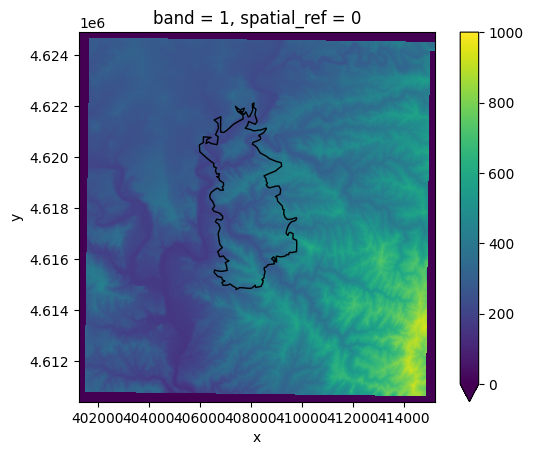

In [8]:
ax = plt.subplot(111)
terrain_f.plot(ax=ax,vmin=0, vmax=1000)
#ba reprojected to terrain_f crs
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

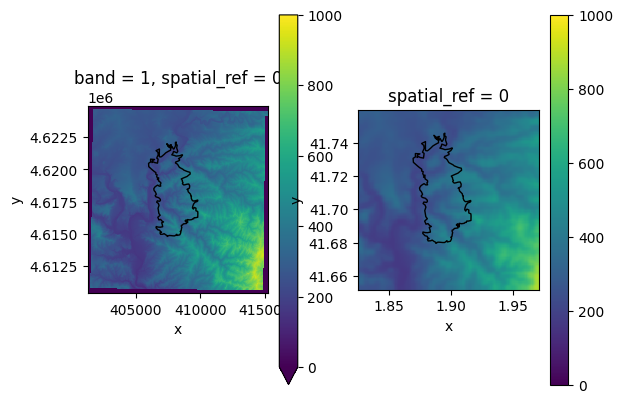

In [9]:
#plot raster with ba
ax = plt.subplot(121)
terrain_f.plot(ax=ax,vmin=0, vmax=1000)
#ba reprojected to terrain_f crs
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')

ax = plt.subplot(122)
terrain_atm_wgs.plot(ax=ax,vmin=0, vmax=1000)
ba.plot(ax=ax,edgecolor='k', facecolor='none')

In [10]:
# Now reproject the terrain_atm_wgs 
#to a the same projection and extdend as terrain_f
terrain_atm = terrain_atm_wgs.rio.reproject_match(terrain_f, nodata=-9999)

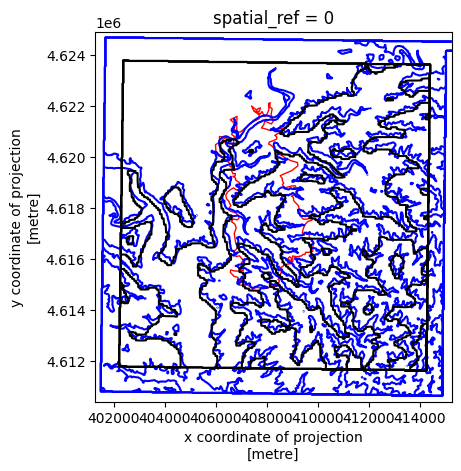

In [11]:
#plot
levels = np.linspace(0, 1000, 10)

ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_atm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none')
ax.set_aspect(1)

#ax = plt.subplot(122)
#terrain_atm.plot(vmin=0,vmax=1000,ax=ax)
#ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')
#ax.set_aspect(1)

In [12]:
#show raster info
print_raster(terrain_f)
print_raster(terrain_atm)

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -247972243
CRS: EPSG:25831

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -1325673559.9103634
CRS: EPSG:25831



Text(0, 0.5, 'topo atm')

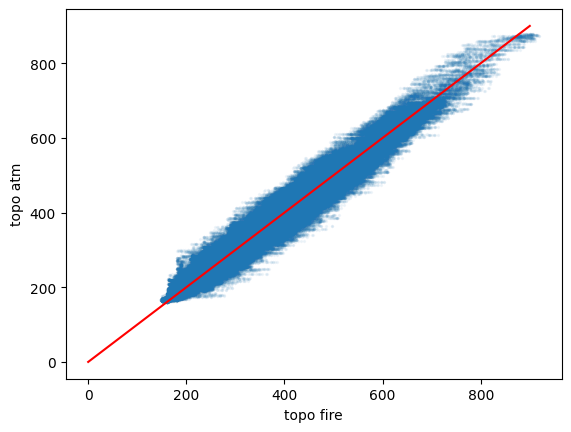

In [13]:
#plot correlation
idxdata = np.where(terrain_atm!=-9999)
ax = plt.subplot(111)
ax.scatter(terrain_f.values[idxdata], terrain_atm.values[idxdata],alpha=.05, s=2)
ax.plot([0,900],[0,900],c='r')
ax.set_xlabel('topo fire')
ax.set_ylabel('topo atm')


In [14]:
#############################################
################load SRTM ###################
#############################################

In [15]:
file_srtm = '/data/IMFSE/PythonCourse/LCP/srtm30m_pdV.tif'
#load terrain from fire
ds_srtm = xrio.open_rasterio(file_srtm, decode_times=False)
terrain_srtm = ds_srtm.isel(band=0)
terrain_srtm = terrain_srtm.rio.reproject_match(terrain_f, nodata=-9999)

In [16]:
#show raster info
print_raster(terrain_f)
print_raster(terrain_srtm)

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -247972243
CRS: EPSG:25831

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: 187076440
CRS: EPSG:25831



Text(0, 0.5, 'topo srtm')

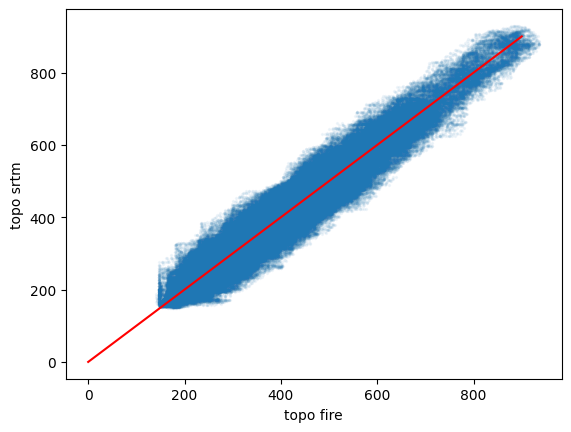

In [17]:
#plot correlation
idxdata=np.where((terrain_srtm!=-9999) & (terrain_f!=-9999))
ax = plt.subplot(111)
ax.scatter(terrain_f.values[idxdata], terrain_srtm.values[idxdata],alpha=.05, s=2)
ax.plot([0,900],[0,900],c='r')
ax.set_xlabel('topo fire')
ax.set_ylabel('topo srtm')

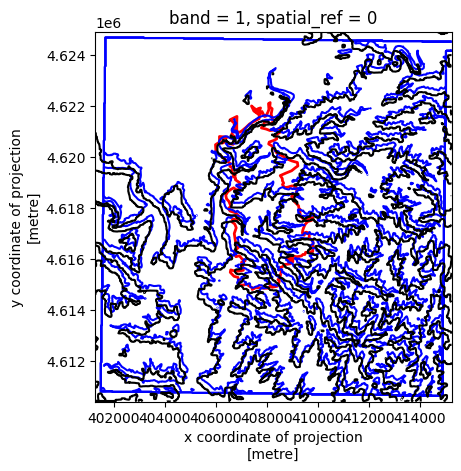

In [18]:
#plot
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)


In [19]:
#############################################
################estimate shift###############
#############################################

In [20]:
import cv2
# code below copy paste from
#https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/

im2_gray = terrain_f.values.astype(np.float32)
im1_gray = terrain_srtm.values.astype(np.float32)

# Create a mask to include the area of interest
mask = np.zeros(im2_gray.shape, dtype=np.uint8)
idxdata = np.where(im2_gray>-50)
mask[idxdata] = 1  # Example mask region
#shrink to avoid border effect
#mask[0,:]=0
#mask[:,0]=0
#mask[-1,:]=0
#mask[:,-1]=0
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((51,51)))

# Find size of image1
sz = im1_gray.shape
 
# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION
 
# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)
 
# Specify the number of iterations.
number_of_iterations = 10000;
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;
 
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC(im1_gray,im2_gray,warp_matrix, warp_mode, criteria, mask)

if warp_mode == cv2.MOTION_HOMOGRAPHY :
# Use warpPerspective for Homography
    im2_aligned = cv2.warpPerspective (im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
# Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    mask_aligned = cv2.warpAffine(mask, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP,borderValue=0);

# Show final results
terrain_f_aligned =im2_aligned

#update terrain_f
terrain_f_old = terrain_f.copy()
terrain_f.values = np.where(mask_aligned==0,-9999,terrain_f_aligned)

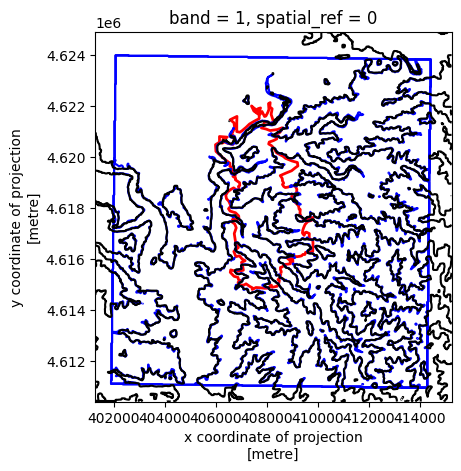

In [22]:
#plot aligned terrain
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)

In [23]:
translation = warp_matrix[:,2] * terrain_srtm.rio.resolution()[0]
print('translation of x={:5.3f} y={:5.3f} m'.format(*translation))

translation of x=92.041 y=-207.072 m


Text(0, 0.5, 'topo srtm')

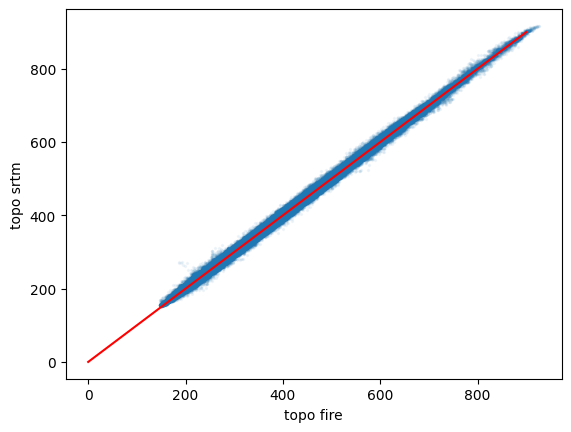

In [24]:
#plot correlation
idxdata=np.where((terrain_srtm.values>-100) & (terrain_f.values>-100))
ax = plt.subplot(111)
ax.scatter(terrain_f.values[idxdata], terrain_srtm.values[idxdata],alpha=.05, s=2)
ax.plot([0,900],[0,900],c='r')
ax.set_xlabel('topo fire')
ax.set_ylabel('topo srtm')

In [25]:
#############################################
################fuelMap in ba###############
#############################################

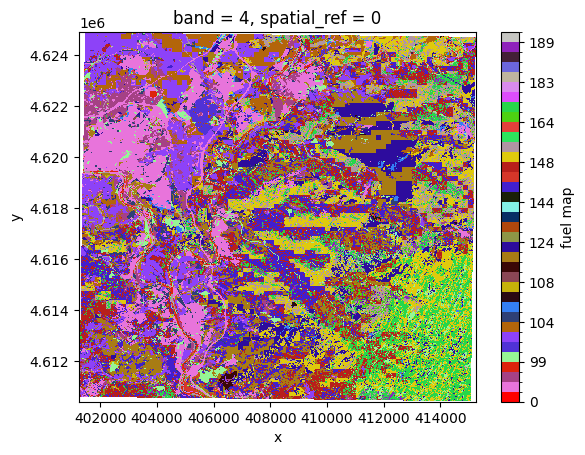

In [26]:
%matplotlib inline
fuelmap_f = ds_f.isel(band=3)
fuelmap_f.name = 'fuel map'

N = len(np.unique(fuelmap_f.values)) -1  # Number of colors
colors = np.random.rand(N, 3) #plt.cm.hsv(np.linspace(0, 1, N))
cmap_fm = mcolors.ListedColormap(colors)
colors[0,:] = [1,0,0]

# Define the boundaries of each color segment
bounds = np.unique(fuelmap_f.values)[1:]  # from 1 to 10
bounds = np.append(bounds, 9999)
norm_fm = mcolors.BoundaryNorm(bounds, cmap_fm.N)

#set no data to not be ploted
nodata_value = -9999
fuelmap_f = fuelmap_f.where(fuelmap_f != nodata_value)

fuelmap_f.plot(cmap=cmap_fm,norm=norm_fm)


In [27]:
from affine import Affine
from rasterio.transform import from_origin
from rasterio.features import geometry_mask

In [28]:
latitude = fuelmap_f['y'].values  # expect reverse order in lat
longitude = fuelmap_f['x'].values

In [29]:
#define the transformation
min_lon = longitude.min()
max_lat = latitude.max()
reslon  = np.diff(longitude).mean()
reslat = np.diff(latitude).mean()
height, width = latitude.shape[0], longitude.shape[0]

transform = Affine.translation(longitude.min(), latitude.max()) * Affine.scale(reslon, reslat)


In [30]:
# Convert geometries to the rasterio format
shapes = [geom for geom in ba.to_crs(fuelmap_f.rio.crs).geometry]

maskBa = geometry_mask(shapes, transform=transform, invert=True, 
                     out_shape=(height, width),all_touched=True).astype(np.uint8)


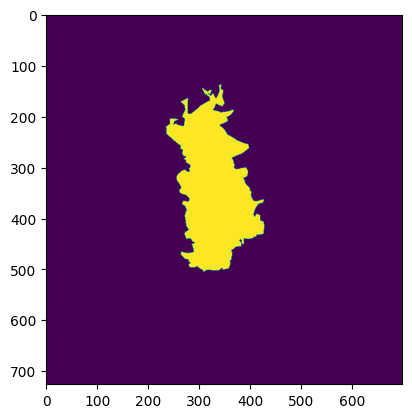

In [31]:
plt.imshow(maskBa)

In [32]:
masked_da = fuelmap_f.where(maskBa == 1)
gdf_fuelMap = masked_da.to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])

In [33]:
gdf_fuelMap

,fuel map
0,93.0
1,93.0
2,123.0
3,93.0
4,93.0
...,...
37811,149.0
37812,149.0
37813,149.0
37814,149.0


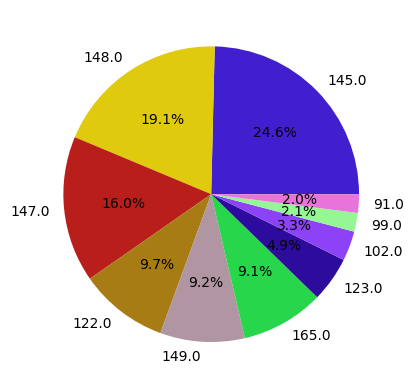

In [34]:
%matplotlib inline
value_counts = gdf_fuelMap['fuel map'].value_counts()

# Plot a pie chart with the top N categories
top_n = 10  # Plot the top 10 most frequent categories
value_counts.head(top_n).plot(kind='pie', autopct='%1.1f%%',colors=cmap_fm(norm_fm(value_counts.index)))

plt.ylabel('')  # Remove y-label for pie chart
plt.show()



In [35]:
#############################################
################aspect vs fuelmap############
#############################################

In [36]:
from scipy import ndimage

def compute_aspect_with_projection(dem: xr.DataArray) -> xr.DataArray:
    """
    Compute the aspect from a DEM (Digital Elevation Model) DataArray, retaining
    the projection and coordinate reference system (CRS) information.
    
    Parameters:
    - dem: xarray.DataArray of the elevation data, with spatial coordinates (e.g., 'x', 'y')
    
    Returns:
    - aspect_da: xarray.DataArray of the aspect in degrees (0-360), retaining the same CRS and projection as the input
    """

    # Compute gradients (slopes) in y and x directions
    grad_y, grad_x = np.gradient(dem, dem['y'], dem['x'])

    # Compute aspect using arctan2, with the formula arctan2(grad_x, -grad_y)
    aspect = np.arctan2(grad_x, -grad_y)

    # Convert aspect from radians to degrees and ensure the range is [0, 360]
    aspect = np.degrees(aspect)
    aspect = (aspect + 360) % 360

    # Create a new DataArray with the same coordinates, dimensions, and projection as the input
    aspect_da = xr.DataArray(
        aspect,
        coords=dem.coords,  # Keep the same coordinates
        dims=dem.dims,      # Keep the same dimensions
        attrs=dem.attrs     # Keep the same attributes (projection, CRS, etc.)
    )

    # Update the name and units to reflect that this is the aspect
    aspect_da.name = 'aspect'
    aspect_da.attrs['units'] = 'degrees'
    aspect_da.attrs['description'] = 'Aspect (degrees clockwise from North)'

    return aspect_da

In [37]:
#compute aspect
aspect_f = compute_aspect_with_projection(terrain_f)
aspect_f_ori = compute_aspect_with_projection(terrain_f_ori)

In [38]:
aspect_f_ori.where(maskBa==1).to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])

,aspect
0,33.690068
1,341.565051
2,45.000000
3,71.565051
4,45.000000
...,...
37811,195.255119
37812,142.125016
37813,156.037511
37814,194.036243


In [39]:
gdf_fuelMap['aspect_f']    =aspect_f.where(maskBa==1).to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])['aspect']
gdf_fuelMap['aspect_f_ori']=aspect_f_ori.where(maskBa==1).to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])['aspect']

In [40]:
gdf_fuelMap

,fuel map,aspect_f,aspect_f_ori
0,93.0,261.940430,33.690068
1,93.0,265.672546,341.565051
2,123.0,249.891876,45.000000
3,93.0,249.562317,71.565051
4,93.0,250.249100,45.000000
...,...,...,...
37811,149.0,223.748505,195.255119
37812,149.0,78.929932,142.125016
37813,149.0,109.740967,156.037511
37814,149.0,160.026062,194.036243


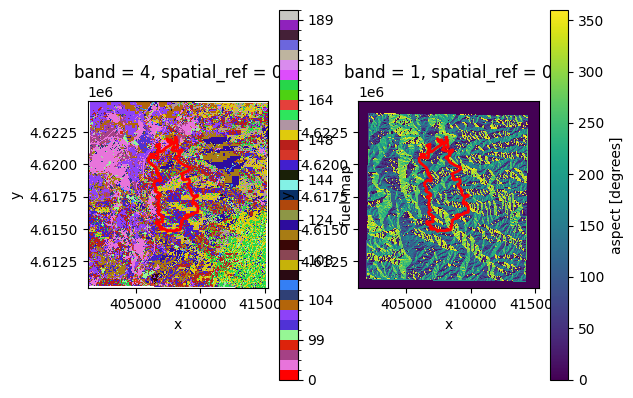

In [41]:
%matplotlib inline
fig = plt.figure()
ax = plt.subplot(121)
fuelmap_f.plot(cmap=cmap_fm,norm=norm_fm,ax=ax)
ba.to_crs(fuelmap_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)

ax = plt.subplot(122)
aspect_f.plot(ax=ax,cmap='viridis',vmin=0,vmax=360)
ba.to_crs(fuelmap_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
fig.canvas.toolbar_visible = True

plt.show()

<Axes: >

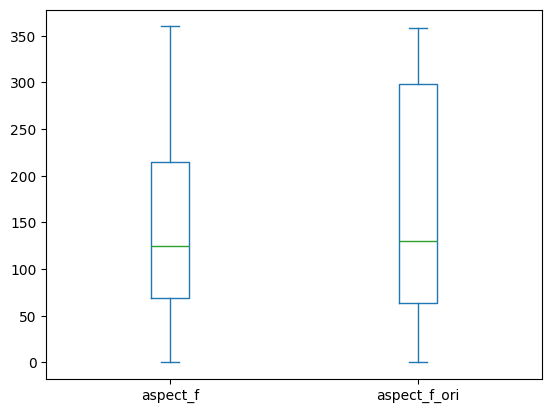

In [42]:
%matplotlib inline
gdf_fuelMap[gdf_fuelMap['fuel map']==145][['aspect_f','aspect_f_ori']].plot(kind='box')